In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [1]:
cd "drive/My Drive/Colab Notebooks/ML_proj2"

/content/drive/My Drive/Colab Notebooks/ML_proj2


In [2]:
ls

 data/                 'selim (1).ipynb'        Untitled0.ipynb
 data_augmentation.py   selim.ipynb             Untitled1.ipynb
 load_helpers.py        submission_to_mask.py   zeineb.ipynb
 __pycache__/           tf_aerial_images.py


In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from skimage import io

import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction import image

#import kerastuner as kt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from data_augmentation import *
from load_helpers import *

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
# Loaded a set of images
root_dir =os.path.join("data", "training")

image_dir = os.path.join(root_dir, "images/")
files = os.listdir(image_dir)
imgs = np.asarray([load_image(image_dir + files[i]) for i in range(len(files))])

gt_dir =  os.path.join(root_dir, "groundtruth/")

gt_imgs = np.asarray([load_image(gt_dir + files[i]) for i in range( len(files))])

In [6]:
len(imgs)

100

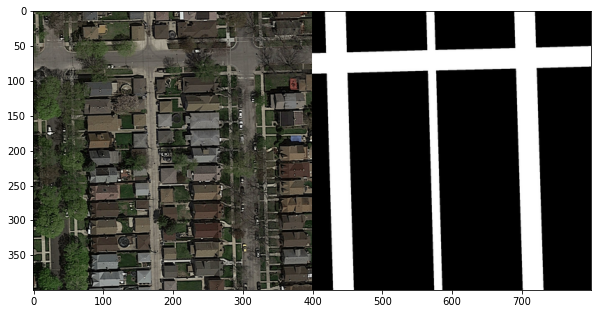

In [7]:
fig1 = plt.figure(figsize=(10, 10))
index = 6
plt.imshow(concatenate_images(imgs[index], gt_imgs[index]))

In [4]:
#run it only once !!!!!!!!! 
#if you wanna run again delete  9dom augmented files!!!!!!!

max_iters=30
augment_dataset2(imgs,gt_imgs,image_dir,gt_dir,max_iters)


here 2


In [6]:
# Loaded a set of images
files_aug = os.listdir(image_dir)
imgs_aug = np.asarray([load_image(image_dir + files_aug[i]) for i in range(len(files_aug))])

files_gt = os.listdir(gt_dir)
gt_imgs_aug = np.asarray([load_image(gt_dir + files_gt[i]) for i in range( len(files_aug))])

In [7]:
print(len(imgs_aug))

448


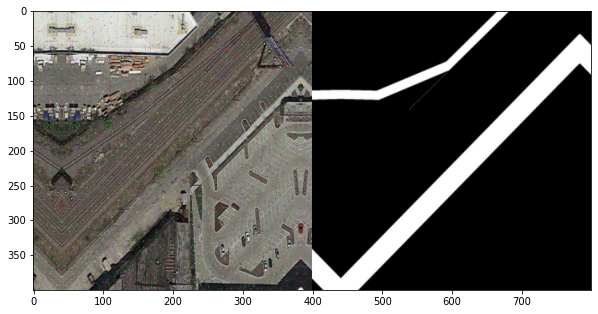

In [21]:
fig1 = plt.figure(figsize=(10, 10))
index = 148
plt.imshow(concatenate_images(imgs_aug[index], gt_imgs_aug[index]))

In [22]:
n = len(imgs)

# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [23]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
X = np.asarray([ img_patches[i] for i in range(len(img_patches))])
Y = np.asarray([value_to_class_NN(gt_patches[i],foreground_threshold) for i in range(len(gt_patches))])

In [24]:
#split train test
test_ratio=0.2
random_state=0
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=test_ratio, random_state=random_state)

In [25]:
#imlement CNN
INPUT_SHAPE=(X_train.shape[1],X_train.shape[2],X_train.shape[3])

INPUT = keras.layers.Input(shape=INPUT_SHAPE)

pool0=keras.layers.AveragePooling2D(pool_size=(2,2),
                                    strides=(1,1))(INPUT)
                                    
conv1 =keras.layers.Conv2D(filters=128,
                           kernel_size=(5,5),
                           strides=(1,1),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE)(pool0)
pool1 = keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same')(conv1)
drop1 = keras.layers.Dropout(0.2)(pool1)

conv2 =  keras.layers.Conv2D(filters=256,
                           kernel_size=(5,5),
                           strides=(2,2),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE)(drop1)    
pool2 = keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same')(conv2)
drop2 = keras.layers.Dropout(0.3)(pool2)


conv3 =  keras.layers.Conv2D(filters=64,
                           kernel_size=(10,10),
                           strides=(2,2),
                           activation='relu',
                           padding='same',
                        input_shape=INPUT_SHAPE)(drop2)  
                        
pool3 = keras.layers.MaxPool2D(pool_size=(2,2),
                               padding='same')(drop2)
drop3 = keras.layers.Dropout(0.3)(pool3)

flat = keras.layers.Flatten()(drop3)

dense1 = keras.layers.Dense(32,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='softmax')(flat)

dense2 = keras.layers.Dense(2,
                            kernel_regularizer=tf.keras.regularizers.l1(0.01),
                            activation='sigmoid')(dense1)

model = keras.Model(inputs=INPUT,outputs=dense2)
print(model.summary())
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 128)       9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)        

In [26]:
model.fit(X_train, Y_train, epochs=3, batch_size=64)

Epoch 1/3
782/782 [==============================] - 176s 225ms/step - loss: 1.0040 - accuracy: 0.7410
Epoch 2/3
782/782 [==============================] - 184s 236ms/step - loss: 0.5995 - accuracy: 0.7418
Epoch 3/3
782/782 [==============================] - 184s 235ms/step - loss: 0.5935 - accuracy: 0.7418


In [27]:
test=model.evaluate(X_test,Y_test)

391/391 [==============================] - 9s 23ms/step - loss: 0.5900 - accuracy: 0.7377
